In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pysar.simulation as psim
from pysar.simulation.plot import *
from pysar.utils import ptime, readfile, writefile, utils as ut, network as pnet, plot as pp
from pysar.objects import timeseries, ifgramStack, sensor
import pysar.ifgram_inversion as ifginv


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_rms_weightFunc'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)


ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'

sensorName = sensor.project_name2sensor_name(ref_dir)[0]

ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)
tbase = np.array(ts_obj.tbase)
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

ref_ifg_file = os.path.join(ref_dir, 'INPUTS/ifgramStack.h5')
stack_obj = ifgramStack(ref_ifg_file)
stack_obj.open()
date12_list = stack_obj.get_date12_list()
#date12_list = ptime.yyyymmdd_date12(pnet.select_pairs_all(date_list))
A, B = stack_obj.get_design_matrix(date12_list=date12_list)
print('number of ifgrams: {}'.format(len(date12_list)))

ts_sim = psim.sim_variable_timeseries(tbase, display=False)
ifgram0 = psim.timeseries2ifgram(ts_sim, date_list, date12_list, display=False)

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_rms_weightFunc
open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
open ifgramStack file: ifgramStack.h5
number of ifgrams: 775


In [11]:
## simulate coherence, ifgram phase with decorrelation noise and estimate coherence
#decor_time = 50.
coh_resid = 0.1
num_sample = 1000
L = 75
weight_func_list = ['Uniform', 'Coherence', 'Variance inv', 'Fisher info']


def simulate_network(decor_day, coh_resid, L=75):
    coh_sim = pnet.simulate_coherence(date12_list,
                                      baseline_file='bl_list.txt',
                                      sensor_name=sensorName,
                                      inc_angle=inc_angle,
                                      decor_time=float(decor_day),
                                      coh_resid=coh_resid)

    decor_noise = psim.simulate_decorrelation_noises(date12_list, coh_sim, L=L, size=num_sample)
    ifgram = decor_noise + np.tile(ifgram0.reshape(-1,1), (1, num_sample))
    coh_est = psim.estimate_coherence(ifgram, L=L, win_size=L)
    return ifgram, coh_sim, coh_est


def get_network_inversion_rms(ifgram, coh_data, min_norm_velocity=True, print_msg=True):
    num = len(weight_func_list)
    rms = np.zeros(num, np.float32)
    for i in range(num):
        weight_func = weight_func_list[i]
        weight = ifginv.coherence2weight(coh_data, weight_func=weight_func, L=L, print_msg=False)
        if weight is not None:
            weight = np.sqrt(weight)
        ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram, weight_sqrt=weight,
                                            min_norm_velocity=min_norm_velocity)[0]
        ts_diff = ts_inv - np.tile(ts_sim.reshape(-1,1), (1, num_sample)) / phase2range
        rms[i] = np.sqrt(np.mean(ts_diff**2))
        if print_msg:
            print('Weight function {} with RMS: {} radian'.format(weight_func, rms[i]))
    return rms, ts_inv

def get_rms_inv(min_norm_velocity, d_step=5, d_max=200):
    decor_time = np.arange(d_step, d_max+d_step, step=d_step, dtype=np.int16).reshape(-1, 1)
    rms_inv = np.zeros((decor_time.size, len(weight_func_list)), np.float32)
    for i in range(decor_time.size):
        ifgram, coh_sim, coh_est = simulate_network(decor_time[i], coh_resid=coh_resid, L=L)
        rms_inv[i, :] = get_network_inversion_rms(ifgram,
                                                  coh_est,
                                                  min_norm_velocity=min_norm_velocity,
                                                  print_msg=False)[0]
        sys.stdout.write('\r{}/{}'.format(i+1, decor_time.size))
        sys.stdout.flush()
    print('')
    txt_data = np.hstack((decor_time.reshape(-1, 1), rms_inv))
    if min_norm_velocity:
        out_file = 'network_inv_rms_minNormVelcity.txt'
    else:
        out_file = 'network_inv_rms_minNormPhase.txt'
    np.savetxt(out_file, txt_data, fmt='%s', delimiter='\t')
    return decor_time, rms_inv
print('Done.')

Done.


In [14]:
## calculate RMS of network inversion
decor_time, rms_inv_minPha = get_rms_inv(min_norm_velocity=False)
decor_time, rms_inv_minVel = get_rms_inv(min_norm_velocity=True)

40/40
40/40


In [75]:
## calculate coherence and weight
c0 = np.linspace(0., 1.0, 50)
weight_norm = np.zeros((c0.size, len(weight_func_list)), np.float32)
for i in range(len(weight_func_list)):
    w0 = ifginv.coherence2weight(c0, weight_func=weight_func_list[i], L=L)
    if w0 is None:
        w0 = np.ones((c0.size), np.float32)
    w0 /= np.max(w0)
    weight_norm[:, i] = w0
print('Done.')

use coherence as weight directly (Perissin & Wang, 2012; Tong et al., 2016)
convert coherence to weight using inverse of phase variance
    with phase PDF for distributed scatterers from Tough et al. (1995)
    number of multilooks L=75
convert coherence to weight using Fisher Information Index (Seymour & Cumming, 1994)
Done.


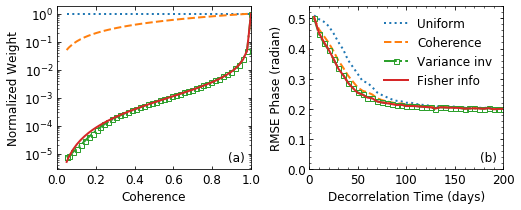

In [85]:
marker_list = [':', '--', '-.s', '-']
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

# subplot - 1
for i in range(len(weight_func_list)):
    ax1.plot(c0, weight_norm[:, i], marker_list[i], lw=2,
             ms=5, mfc='none', label=weight_func_list[i])
ax1.set_yscale('log')
ax1.set_xlabel('Coherence', fontsize=font_size)
ax1.set_ylabel('Normalized Weight', fontSize=font_size)
ax1.set_xlim([0., 1.])

# subplot - 2
for i in range(len(weight_func_list)):
    ax2.plot(decor_time.reshape(-1, 1), rms_inv_minVel[:, i], marker_list[i], lw=2,
             ms=5, mfc='none', label=weight_func_list[i])
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim((0, 200))
ax2.set_ylim((0., 0.54))
ax2.set_xlabel('Decorrelation Time (days)', fontsize=font_size)
ax2.set_ylabel('RMSE Phase (radian)', fontsize=font_size)

ax2.legend(fontsize=font_size, frameon=False)
for ax in [ax1, ax2]:
    ax.tick_params(which='both', direction='in', labelsize=font_size,
                   bottom=True, top=True, left=True, right=True)
ax1.annotate('(a)', xy=(0.88, 0.05), fontsize=font_size, xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.88, 0.05), fontsize=font_size, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.3)

plt.savefig('netInv_weightFunc.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

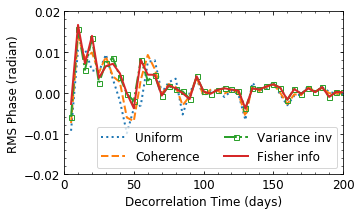

In [43]:
fig, ax = plt.subplots(figsize=[5, 3])
for i in range(len(weight_func_list)):
    ax.plot(decor_time.reshape(-1, 1), rms_inv_minVel[:, i] - rms_inv_minPha[:, i], marker_list[i], lw=2,
            ms=5, mfc='none', label=weight_func_list[i])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim((0, 200))
ax.set_ylim((-0.02, 0.02))
plt.xlabel('Decorrelation Time (days)', fontsize=font_size)
plt.ylabel('RMS Phase (radian)', fontsize=font_size)
plt.legend(fontsize=font_size, ncol=2)
plt.savefig('netInv_rms_minVel-minPha.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

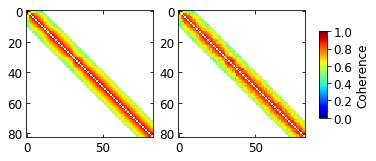

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[5, 3])
for ax, data in zip(axs, [coh_sim, coh_est]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    im = ax.imshow(data_mat, vmin=0, vmax=1., cmap='jet')
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.94, 0.3, 0.02, 0.4])
cbar = plt.colorbar(im, cax)
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.savefig('')
plt.show()

In [54]:
cbar.ax

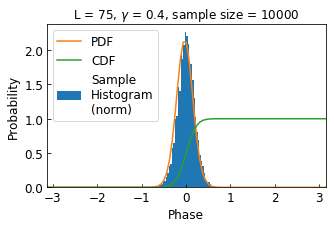

In [30]:
x = psim.sample_decorrelation_phase(L, 0.4, size=10000, display=True)

In [14]:
np.arange(10, 1000, step=10).size

99